# RNN with and without context
*CINPLA, 2024*

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
import umap
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist

from tqdm import tqdm
import os

from src.models import ContextSpaceNet, OldSpaceNet, RecurrentSpaceNet, Decoder, End2EndSpaceNet
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.rcdefaults()
plt.style.use("figures/project_style.mplstyle")
%matplotlib inline

Helper functions

In [3]:
def get_ratemaps(model, bins=32, timesteps=10, n_traj=50000, context=1, context_in_initial=False):
    """
    Get ratemaps for a rnn context model.
    
    Parameters
    ----------
    model : torch.nn.Module
        Model to get ratemaps for.
    bins : int
        Number of bins for the ratemaps.
    timesteps : int
        Number of timesteps in the trajectories.
    n_traj : int
        Number of trajectories to generate.
    context : float
        Context value to use.
    
    Returns
    -------
    ratemap : np.ndarray
        Ratemap of shape (bins, bins).
    """
    
    # Generate dataset
    genny = SimpleDatasetMaker()    
    r, v = genny.generate_dataset(n_traj, timesteps)
    
    # BSR
    c = torch.ones(n_traj, timesteps-1, 1) * context
    input = torch.cat((v, c), dim = -1)
    
    if context_in_initial:
        initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)
    else:
        initial_input = r[:, 0]
    
    # Get spatial representation
    p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
    p = p.detach().numpy()
    ps = p.reshape(-1, p.shape[-1])
    
    rs = r[:, 1:].detach().numpy().reshape(-1, 2)
    ratemap, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=bins)
        
    return ratemap

def characterize_transformation(T):
    """
    Characterizes a transformation matrix T.
    """
    
    # Compute SVD to get singular values
    U, singular_values, Vt = np.linalg.svd(T)
    
    # Condition number
    cond_number = singular_values.max() / singular_values.min()
    
    # Frobenius norm
    fro_norm = np.linalg.norm(T, 'fro')
    
    # Eigenvalues (if T is square)
    if T.shape[0] == T.shape[1]:
        eigenvalues, _ = np.linalg.eig(T)
    else:
        eigenvalues = None
    
    det = np.linalg.det(T)
    
    return {
        "Singular Values": singular_values,
        "Condition Number": cond_number,
        "Frobenius Norm": fro_norm,
        "Eigenvalues": eigenvalues,
        "Determinant": det
    }

def get_orthogonal_transformation(A, B):
    """
    Finds an orthogonal transformation matrix T that maps A to B.
    
    Parameters
    ----------
    A : np.ndarray
        Matrix of shape (n_units, positions)
    B : np.ndarray
        Matrix of shape (n_units, positions)
    
    Returns
    -------
    T : np.ndarray
        Orthogonal transformation matrix of shape (n_units, n_units)
    """
    # Center the data
    A_centered = A - np.mean(A, axis=1, keepdims=True)
    B_centered = B - np.mean(B, axis=1, keepdims=True)
        
    # Compute the cross-covariance matrix
    C = A_centered @ B_centered.T

    # Compute the SVD of the cross-covariance matrix
    U, S, Vt = np.linalg.svd(C)

    # Calculate the transformation matrix
    T = Vt.T @ U.T

    return T


Define paths

In [4]:
figure_path = '/Users/frederikrogge/Documents/Projekte/PhD/Projects/BSR/figures-new'
path = "/Users/frederikrogge/Data/bsr/rnn-new"

# RNN

Train models

In [7]:
# ----------------------- Params -----------------------
train_steps = 50000
timesteps = 10          # Length of trajectories
bs = 64                 # Batch size
n_in = 2                # Cartesian coordinates + 1 context
lr = 1e-4               # Learning rate
beta = 0.5              # Rescaling parameter
scale = 0.25            # Scale of the spatial representation
n_out = 100             # Number of units in the spatial representation

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Analyze for different model parameters
models = {   
    # "100 units 01 scale": [RecurrentSpaceNet(n_in=n_in, n_out=100, corr_across_space=True, scale=0.1, device=device) for _ in range(2)],
    "100 units": [RecurrentSpaceNet(n_in=n_in, n_out=n_out, corr_across_space=True, scale=scale, beta=beta, device=device) for _ in range(10)],
}

loss_histories = {name: [] for name in models.keys()}

# --------------------- Training ----------------------

for name, model_list in models.items():
    
    print(f"Training {name}")
    for i, model in enumerate(model_list):
        print(f"Model {i+1}")
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        genny = SimpleDatasetMaker()    # use simple dataset
        
        if os.path.exists(f"{path}/{name}_{i}.pt"):
            model = torch.load(f"{path}/{name}_{i}.pt")
            loss_history = np.load(f"{path}/{name}_{i}_loss_history.npy")
            loss_histories[name].append(loss_history)
            continue
        
        loss_history = []
        progress = tqdm(range(train_steps))
        for k in progress:  
            
            # Create data
            r, v = genny.generate_dataset(bs, timesteps, device=device)
        
            # Train step
            loss = model.train_step(x=(v, r[:, 0]), y=r[:, 1:], optimizer=optimizer)
        
            loss_history.append(loss)
            
            if k % 10 == 0:
                progress.set_description(f"loss: {loss:>7f}")
                
        models[name][i] = model
        loss_histories[name].append(loss_history)

        # Save model and loss history
        torch.save(model, f"{path}/{name}_{i}.pt")
        np.save(f"{path}/{name}_{i}_loss_history.npy", loss_history)


Training 100 units
Model 1


loss: 0.000785:  97%|█████████▋| 48569/50000 [13:21<00:23, 60.57it/s] 


KeyboardInterrupt: 

Load results

In [40]:
# Load models
models = {
    "100 units": [torch.load(f"{path}/100 units_{i}.pt") for i in range(10)],
}

# Load loss histories
loss_histories = {name: [np.load(f"{path}/{name}_{i}_loss_history.npy") for i in range(2)] for name in models.keys()}

model_name_map = {
    "100 units": "n=100, $\sigma$=0.25",
    "500 units": "n=500, $\sigma$=0.25",
    "1000 units": "n=1000, $\sigma$=0.25",
    "100 units 01 scale": r"n=100, $\sigma$=0.1",
    "100 units 05 scale": r"n=100, $\sigma$=0.5",
    "1000 units 01 scale": r"n=1000, $\sigma$=0.1",
    'w/o context': 'w/o context',
    'with context': 'with context',
}

## Example trajectories

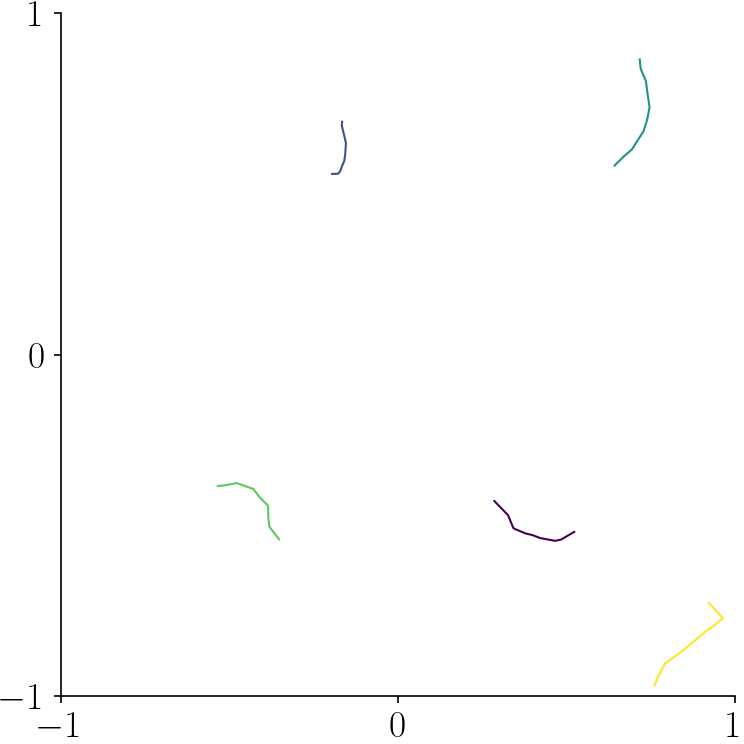

In [41]:
cmap = plt.get_cmap("viridis")

# Create datatset maker
genny = SimpleDatasetMaker()

# Generate dataset
r, v = genny.generate_dataset(5, 10)

# Get colors
colors = [cmap(i) for i in np.linspace(0, 1, r.shape[0])]

fig, ax = plt.subplots(figsize=(5, 5))

for k, traj in enumerate(r):
    ax.plot(*traj.detach().numpy().T, color=colors[k], lw=1)
    # ax.plot(*traj.detach().numpy().T, color='black', lw=1)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 1)

# Set ticks
ax.set_xticks(np.linspace(-1, 1, 3))
ax.set_yticks(np.linspace(-1, 1, 3))

plt.show()

# fig.savefig(os.path.join(figure_path, 'rnn_example_trajectories.svg'), transparent=True)

## Loss

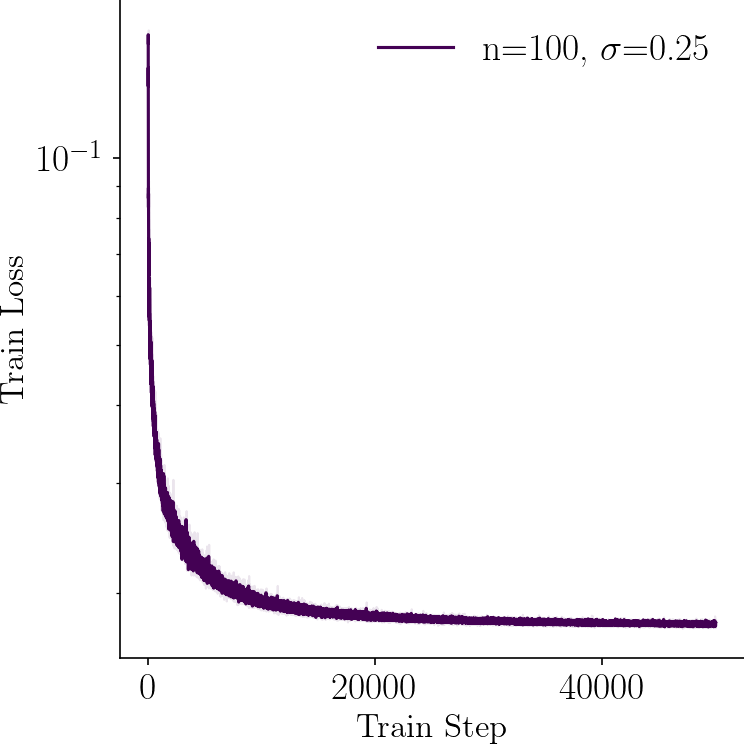

In [42]:
# Load viridis colormap
cmap = plt.get_cmap("viridis")

colors = [cmap(i) for i in np.linspace(0, 1, len(models))]

# Plot performance
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1.5)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()

# fig.savefig(os.path.join(figure_path, 'rnn_training_loss.svg'), transparent=True)
plt.show()


## Ratemaps

In [43]:
# Load model
model_name = "100 units"
model = models[model_name][0]

In [44]:
timesteps = 10
n_bins = 128

genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(100000, timesteps)
p, _ = model.spatial_representation(v, model.p0(r[:, 0])[None])
p = p.detach().numpy()

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=n_bins)

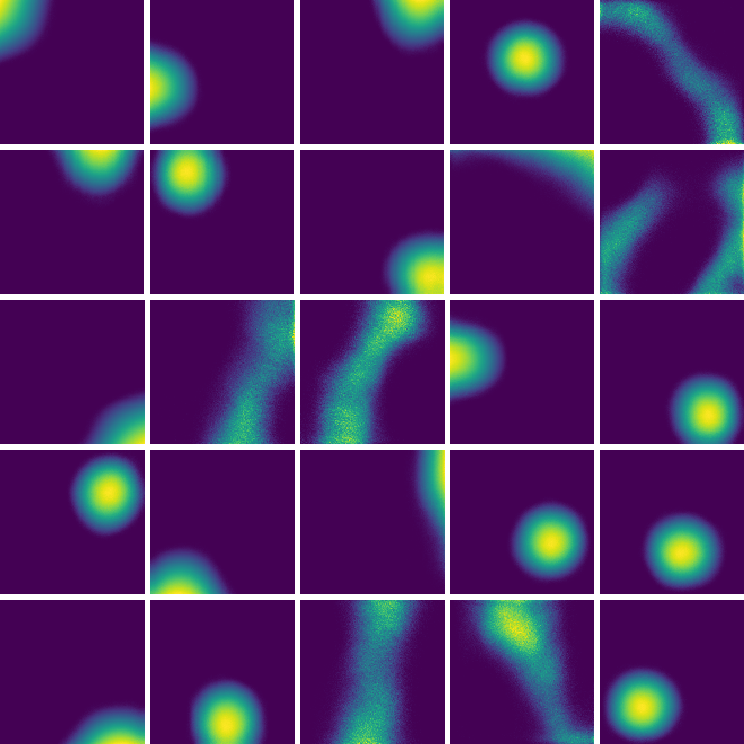

In [45]:
# Optionally, select a subset of ratemaps
plt_ratemaps = ratemaps
# plt_ratemaps = ratemaps[np.mean(ratemaps, axis=(1, 2)) < 0.025]

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(plt_ratemaps[:25], cols=5, cmap="viridis")     
plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_ratemaps_{model_name}.svg'), transparent=True)

We see kind of two modes here:
- low peak and small mean rate seems to characterize band cells
- high peak and high mean reate seems to characterize place cells

Text(0.5, 0, 'Peak')

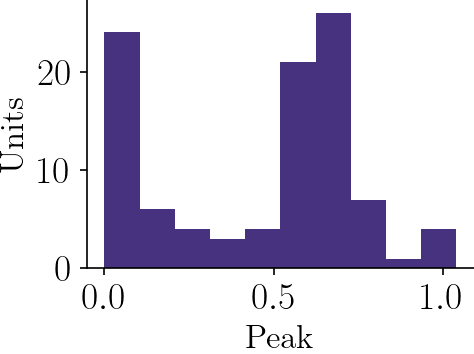

In [14]:
fig, ax = plt.subplots()
ax.hist(np.max(ratemaps, axis=(1, 2)))
ax.set_ylabel("Units")
ax.set_xlabel("Peak")

# fig.savefig(os.path.join(figure_path, 'rnn_peaks.svg'), transparent=True)   

Text(0.5, 0, 'Mean rate')

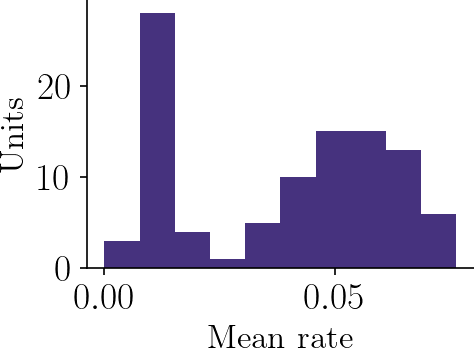

In [15]:
fig, ax = plt.subplots()
ax.hist(np.mean(ratemaps, axis=(1, 2)))
ax.set_ylabel("Units")
ax.set_xlabel("Mean rate")

# fig.savefig(os.path.join(figure_path, 'rnn_mean_rates.svg'), transparent=True) 

## Eigenvalues

In [28]:
# Load models
model_dict = {
    'w/o context': torch.load(os.path.join(path, '100 units_0.pt')),
    'with context': torch.load(os.path.join(path, '100 units context_0.pt')),
}

In [29]:
cmap = plt.get_cmap("viridis")

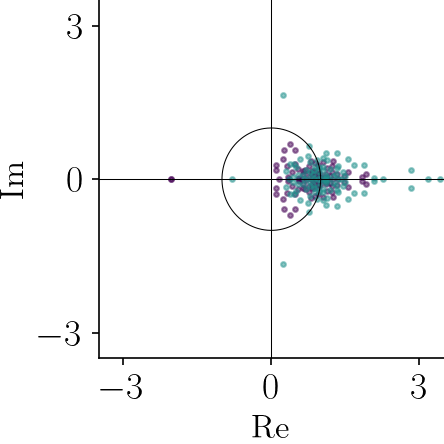

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))

colors = [cmap(i) for i in np.linspace(0, 0.5, len(model_dict))]

for i, (model_name, model) in enumerate(model_dict.items()):
    
    # Get weight matrix
    weight_matrix = model.spatial_representation.weight_hh_l0.data.numpy()
    
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(weight_matrix)

    ax.scatter(eigenvalues.real, eigenvalues.imag, color=colors[i], s=5, alpha=.5)
    
    ax.scatter(eigenvalues.real[0], eigenvalues.imag[0], color=colors[i], label=model_name, s=5, alpha=0.5)

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Re')
ax.set_ylabel('Im')
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)
ax.set_ylim(-3.5, 3.5)
ax.set_xlim(-3.5, 3.5)

# Add a unit circle
theta = np.linspace(0, 2*np.pi, 100)  # Parameterize the circle
x = np.cos(theta)  # X coordinates
y = np.sin(theta)  # Y coordinates
ax.plot(x, y, c='black', lw=0.5)

# Add ticks
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-3, 0, 3])

plt.show()

fig.savefig(os.path.join(figure_path, 'rnn_eigenvectors.svg'), transparent=True)

## Spatial similarity / Error maps

In [16]:
model_name = "100 units"
model = models[model_name][0]

pos_name = "corner"
scale = 0.25
timesteps = 10
n = 128

positions = {
    'center': [64, 64],
    'corner': [0, 0],
    'bottom': [32, 64]
}

pos = positions[pos_name]

In [17]:
r, v = genny.generate_dataset(100000, timesteps)

p, _ = model.spatial_representation(v, model.p0(r[:, 0])[None])
p = p.detach().numpy()

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, a, b, c = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=n)

In [18]:
p = ratemaps.reshape(100, -1).T 

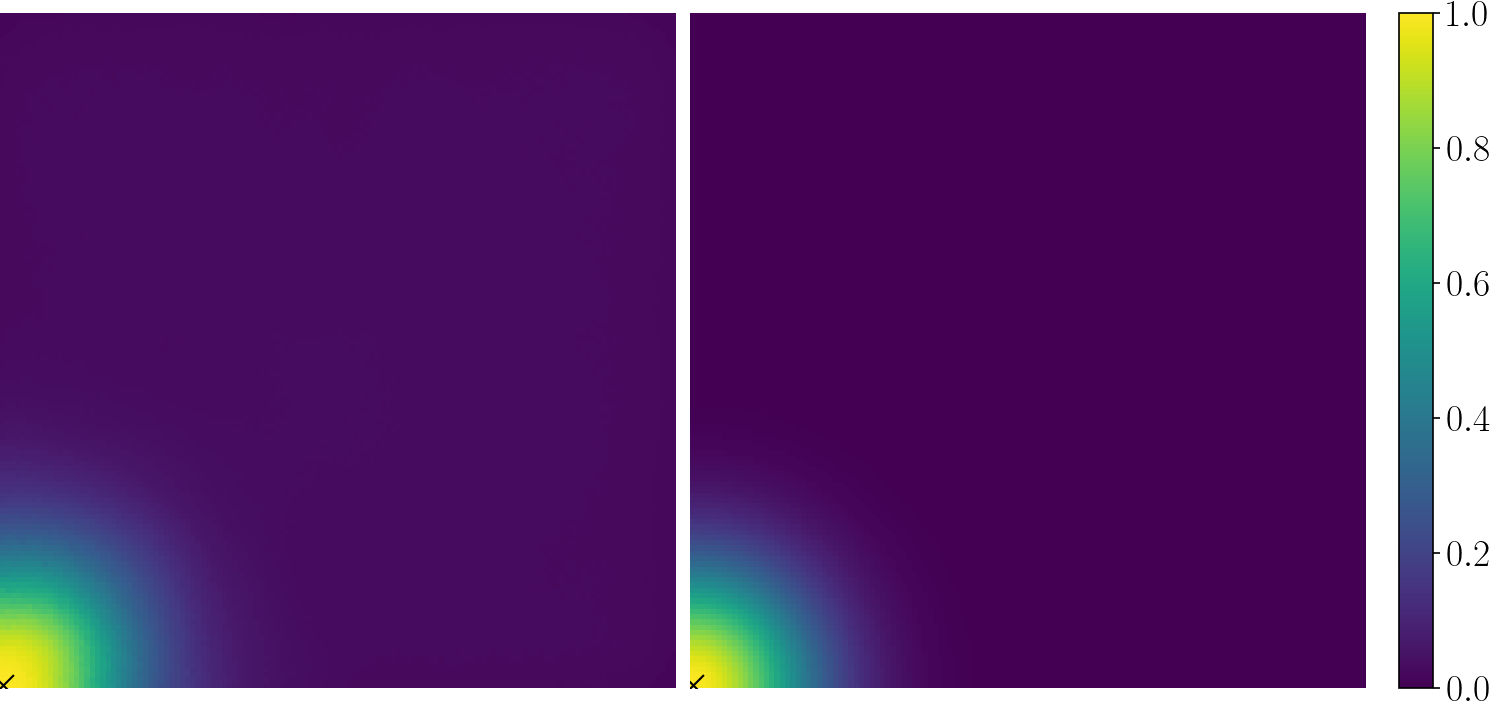

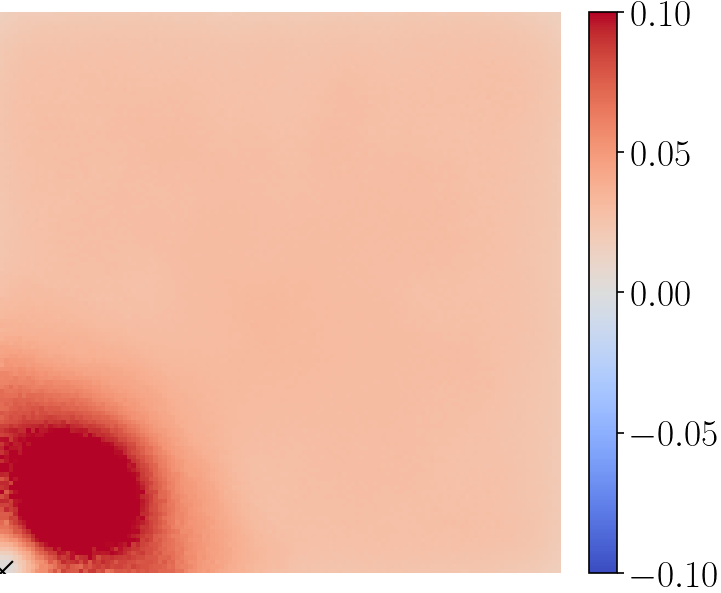

In [19]:
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) **2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) **2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(5, 5))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

# RNN with context

Train models

In [57]:
# ----------------------- Params -----------------------
train_steps = 50000
timesteps = 10          # Length of trajectories
bs = 32                 # Batch size
n_in = 3                # Cartesian coordinates + 1 context
context_in_initial = True
lr = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial_state_size = 3 if context_in_initial else 2

# Analyze for different model parameters
models = {   
    "100 units context initial state": [RecurrentSpaceNet(n_in=n_in, n_out=100, corr_across_space=True, scale=0.25, device=device, initial_state_size=initial_state_size) for _ in range(10)],
}

loss_histories = {name: [] for name in models.keys()}

# --------------------- Training ----------------------

for name, model_list in models.items():
    
    print(f"Training {name}")
    for i, model in enumerate(model_list):
        print(f"Model {i+1}")
        
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        genny = SimpleDatasetMaker()    # use simple dataset
        
        loss_history = []
        progress = tqdm(range(train_steps))
        for k in progress:  
            
            # Create data
            r, v = genny.generate_dataset(bs, timesteps, device=device)
                    
            # Get random contexts and use for all timesteps along a trajectory
            c = torch.tensor(np.random.uniform(-5, 5, bs), dtype=torch.float32, device=device)
            c = c[:, None, None] * torch.ones((1, timesteps - 1, 1), device=device)
            
            # Build initial input
            if context_in_initial:
                initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)
            else:
                initial_input = r[:, 0]
            
            inputs = (torch.cat((v, c), dim=-1), initial_input)
            labels = (r[:, 1:], c)
        
            loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)
        
            loss_history.append(loss)
            
            if k % 10 == 0:
                progress.set_description(f"loss: {loss:>7f}")
                
        models[name][i] = model
        loss_histories[name].append(loss_history)

        # Save model and loss history
        torch.save(model, f"{path}/{name}_{i}.pt")
        np.save(f"{path}/{name}_{i}_loss_history.npy", loss_history)

Training 100 units context initial state
Model 1


loss: 0.019947: 100%|██████████| 50000/50000 [03:11<00:00, 261.27it/s]


Model 2


loss: 0.018888: 100%|██████████| 50000/50000 [03:14<00:00, 257.40it/s]


Model 3


loss: 0.019738: 100%|██████████| 50000/50000 [03:16<00:00, 254.78it/s]


Model 4


loss: 0.020259: 100%|██████████| 50000/50000 [03:07<00:00, 266.65it/s]


Model 5


loss: 0.019696: 100%|██████████| 50000/50000 [03:17<00:00, 253.67it/s]


Model 6


loss: 0.019728: 100%|██████████| 50000/50000 [03:12<00:00, 259.37it/s]


Model 7


loss: 0.019689: 100%|██████████| 50000/50000 [03:09<00:00, 263.16it/s]


Model 8


loss: 0.020496: 100%|██████████| 50000/50000 [03:08<00:00, 265.79it/s]


Model 9


loss: 0.020872: 100%|██████████| 50000/50000 [03:13<00:00, 257.89it/s]


Model 10


loss: 0.019717: 100%|██████████| 50000/50000 [03:16<00:00, 253.94it/s]


Load results

In [58]:
# Load models
models = {
    "100 units context initial state": [torch.load(f"{path}/100 units context initial state_{i}.pt") for i in range(10)],
    "100 units context": [torch.load(f"{path}/100 units context_{i}.pt") for i in range(10)],
    
    # "100 units no context loss": [torch.load(f"{path}/100 units_no_context_loss_{i}.pt") for i in range(10)],
    # "500 units": [torch.load(f"{path}/500 units_{i}.pt") for i in range(10)],
    # "1000 units": [torch.load(f"{path}/1000 units_{i}.pt") for i in range(10)],
    # "100 units 01 scale": [torch.load(f"{path}/100 units 01 scale_{i}.pt") for i in range(10)],
    # "100 units 05 scale": [torch.load(f"{path}/100 units 05 scale_{i}.pt") for i in range(10)],
    # "1000 units 01 scale": [torch.load(f"{path}/1000 units 01 scale_{i}.pt") for i in range(10)],
}

# Load loss histories
loss_histories = {name: [np.load(f"{path}/{name}_{i}_loss_history.npy") for i in range(10)] for name in models.keys()}

# loss_histories = {
#     'w/o context': [np.load(f"/Users/frederikrogge/Data/bsr/rnn/100 units_{i}_loss_history.npy") for i in range(10)],
#     'with context': [np.load(f"/Users/frederikrogge/Data/bsr/rnn-context/100 units_{i}_loss_history.npy") for i in range(10)],
# }

model_name_map = {
    "100 units": "n=100, $\sigma$=0.25",
    "100 units context initial state": "n=100, $\sigma$=0.25",
    "100 units context": "n=100, $\sigma$=0.25",
    "500 units": "n=500, $\sigma$=0.25",
    "1000 units": "n=1000, $\sigma$=0.25",
    "100 units 01 scale": r"n=100, $\sigma$=0.1",
    "100 units 05 scale": r"n=100, $\sigma$=0.5",
    "1000 units 01 scale": r"n=1000, $\sigma$=0.1",
    'w/o context': 'w/o context',
    'with context': 'with context',
}

## Loss

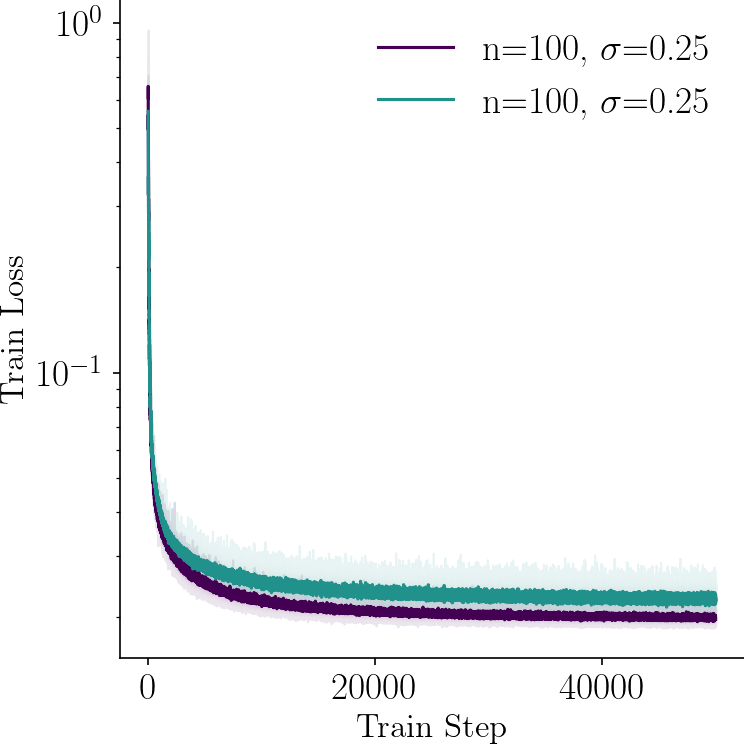

In [59]:
# Load viridis colormap
cmap = plt.get_cmap("viridis")

colors = [cmap(i) for i in np.linspace(0, 0.5, len(loss_histories))]

# Plot performance
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
for i, (name, loss_history) in enumerate(loss_histories.items()):
    ax.semilogy(np.arange(len(loss_history[0])), np.mean(loss_history, axis=0), label=model_name_map[name], color=colors[i], lw=1.5)
    ax.fill_between(np.arange(len(loss_history[0])), np.min(loss_history, axis=0), np.max(loss_history, axis=0), alpha=0.1, color=colors[i])
ax.set_xlabel("Train Step")
ax.set_ylabel("Train Loss")
ax.legend()

# fig.savefig(os.path.join(figure_path, 'rnn_loss_history.svg'), transparent=True)
plt.show()


## Ratemaps

In [101]:
# Load model
model_name = "100 units context"
model_name = "100 units context initial state"
# model_name = "100 units no context loss"
model = models[model_name][0]

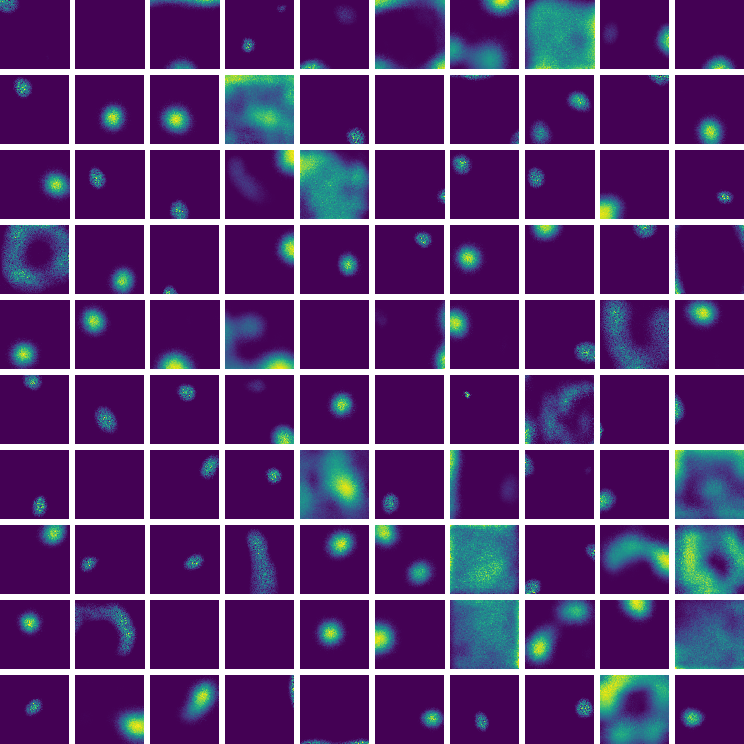

In [93]:
context = -5
context_in_initial = False

# Get ratemaps
ratemaps = get_ratemaps(model, bins=128, timesteps=10, n_traj=100000, context=context, context_in_initial=context_in_initial)

# Plot first 25 ratemaps (active units)
fig, ax = ratemap_collage(ratemaps[:100], cols=10, cmap="viridis")      # jet, viridis
plt.show()

fig.savefig(os.path.join(figure_path, f'{model_name}_ratemaps.png'), transparent=True)

In [87]:
context_1 = -5
context_2 = 0

ratemaps_1 = get_ratemaps(model, bins=128, timesteps=10, n_traj=100000, context=context_1, context_in_initial=context_in_initial)
ratemaps_2 = get_ratemaps(model, bins=128, timesteps=10, n_traj=100000, context=context_2, context_in_initial=context_in_initial)

np.corrcoef(ratemaps_1.flatten(), ratemaps_2.flatten())[0, 1]

0.37154669476139135

In [67]:
ratemaps_1.shape

(100, 128, 128)

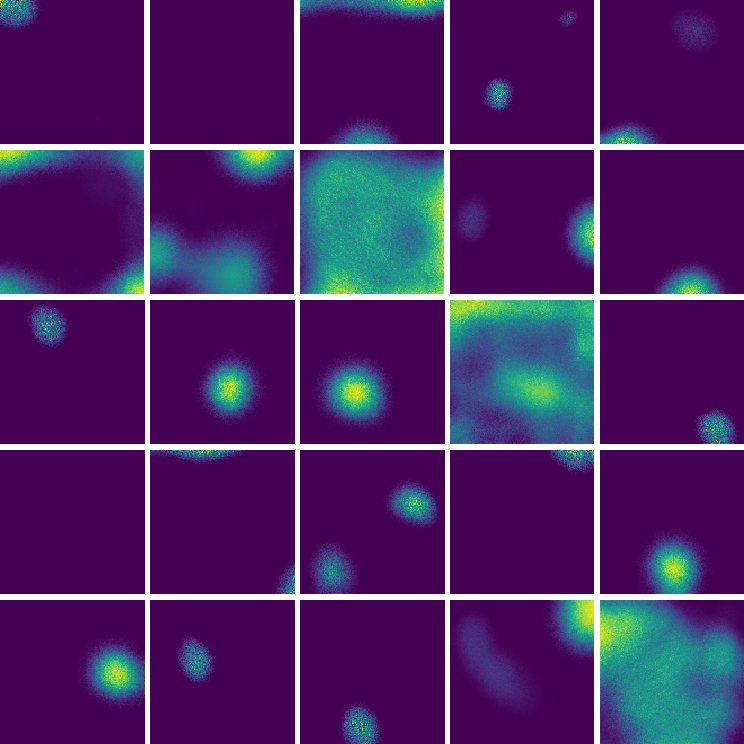

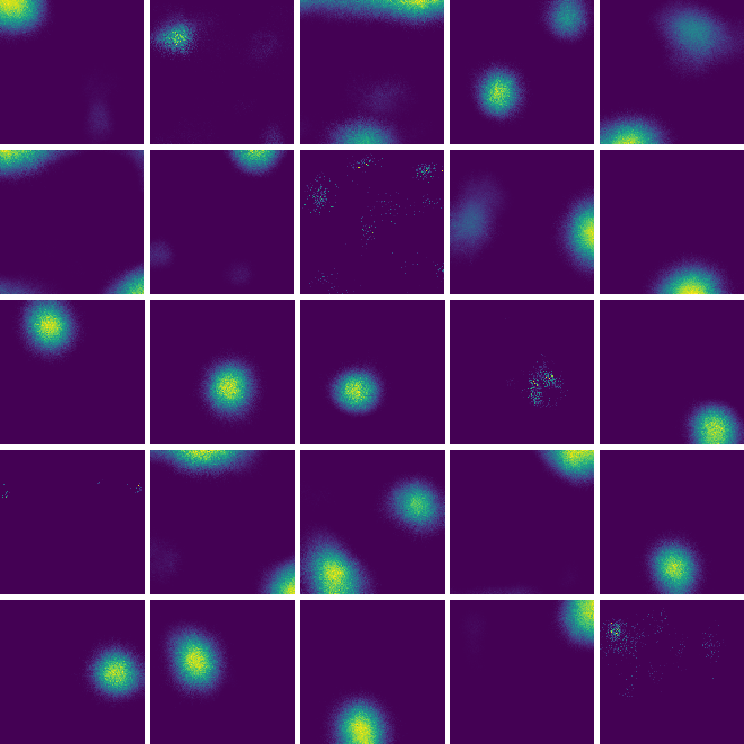

In [88]:
fig, ax = ratemap_collage(ratemaps_1[:25], cols=5, cmap="viridis")
fig.savefig(os.path.join(figure_path, f'{model_name}_ratemaps_context_1.png'), transparent=True)
plt.show()

fig, ax = ratemap_collage(ratemaps_2[:25], cols=5, cmap="viridis")
fig.savefig(os.path.join(figure_path, f'{model_name}_ratemaps_context_2.png'), transparent=True)
plt.show()

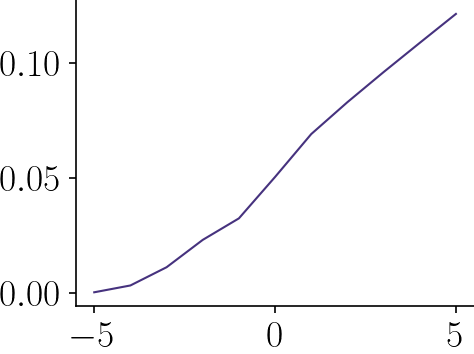

In [70]:
context_1 = -5

ratemaps_1 = get_ratemaps(model, bins=128, timesteps=10, n_traj=50000, context=context_1, context_in_initial=context_in_initial)

dists = []
for context_2 in np.arange(-5, 6, 1):
    ratemaps_2 = get_ratemaps(model, bins=128, timesteps=10, n_traj=50000, context=context_2, context_in_initial=context_in_initial)
    
    dist = np.mean((ratemaps_1[:, 1, 1] - ratemaps_2[:, 1, 1]) ** 2)
    dists.append(dist)
    
fig, ax = plt.subplots()
ax.plot(np.arange(-5, 6, 1), np.array(dists) / 0.25)
plt.show()


## Error maps

In [ ]:
model_name = "100 units"
model = models[model_name][0]

pos_name = "corner"
scale = 0.25

positions = {
    'center': [64, 64],
    'corner': [0, 0],
    'bottom': [32, 64]
}

pos = positions[pos_name]

timesteps = 10
context = -5
n = 128

In [ ]:
r, v = genny.generate_dataset(100000, timesteps)
c = torch.ones(r.shape[0], timesteps-1, 1) * context
input = torch.cat((v, c), dim = -1)

p,_ = model.spatial_representation(input, model.p0(r[:, 0])[None])

In [ ]:
p = p.detach().numpy()

ps = p.reshape(-1, p.shape[-1])
rs = r[:, 1:].detach().numpy().reshape(-1, 2)
ratemaps, a, b, c = stats.binned_statistic_2d(rs[:, 0], rs[:, 1], ps.T, bins=n)
p = ratemaps.reshape(100, -1).T
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# Define grid
grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)

# Compute position in flat array
pos_flat = np.ravel_multi_index(pos, (n, n))

# Compute similarity of the 'p' based on this, but with numpy
dp = cdist(p, p[pos_flat][None]) ** 2
corr = np.exp(-dp)

# Same for actual grid
grid_dist = cdist(grid, grid[pos_flat][None]) ** 2
grid_corr = np.exp((-0.5 / scale ** 2) * grid_dist)

# Create figure
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Spatial representations
im = axs[0].imshow(corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[0].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[0].axis("off")

# Grid
im = axs[1].imshow(grid_corr.reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=1)
axs[1].scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs[1].axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_{pos_name}_{model_name}.svg'), transparent=True)

# Difference
fig, axs = plt.subplots(figsize=(5, 5))
# im = axs.imshow(np.abs(corr - grid_corr).reshape(n, n), origin="lower", cmap="viridis", vmin=0, vmax=0.1)
im = axs.imshow((corr - grid_corr).reshape(n, n), origin="lower", cmap="coolwarm", vmin=-0.1, vmax=0.1)
axs.scatter(pos[1], pos[0], marker="x", color="black", s=100)
axs.axis("off")

# Add a colorbar to the figure
fig.colorbar(im, ax=axs, orientation='vertical', fraction=.05)

plt.show()

# fig.savefig(os.path.join(figure_path, f'rnn_similarity_structure_error_{pos_name}_{model_name}.svg'), transparent=True)

## UMAP

In [102]:
cmap = plt.get_cmap("viridis")

In [122]:
contexts = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
contexts = [-5, -3, 0, 3, 5]
# contexts = [-5, 0, 5]
context_colors = [cmap(i) for i in np.linspace(0, 1, len(contexts))]

In [123]:
# Load model
model_name = "100 units context"
model_name = "100 units context initial state"
# model_name = "100 units no context loss"
model = models[model_name][0]

# visualize representations
n_plot = 50000               # For umap trajectories choose 5000, for maps something like 50000  
timesteps = 10
bins = 32
context_in_initial = True

representations, colors, ratemaps = [], [], []
for i, context in enumerate(contexts):
    
    # Generate dataset
    r, v = genny.generate_dataset(n_plot, timesteps)
    
    # BSR
    c = torch.ones(n_plot, timesteps-1, 1) * context
    input = torch.cat((v, c), dim = -1)
    
    # Get initial input
    if context_in_initial:
        initial_input = torch.cat((r[:, 0], c[:, 0]), dim=-1)
    else:
        initial_input = r[:, 0]
    
    # Get spatial representation
    p,_ = model.spatial_representation(input, model.p0(initial_input)[None])
    p = p.detach().numpy()
    ps = p.reshape(-1, p.shape[-1])
    
    rs = r[:, 1:].detach().numpy().reshape(-1, 2)
    ratemap, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=bins)
    
    representations.append(ps)
    colors.extend([context_colors[i]] * ps.shape[0])
    ratemaps.append(ratemap.reshape(100, -1).T)

# Concatenate
representations = np.concatenate(representations, axis=0)
ratemaps = np.concatenate(ratemaps, axis=0)

UMAP on individual concatenated trajectories

In [109]:
reducer = umap.UMAP(n_components=2)
umap_trajectories = reducer.fit_transform(representations)

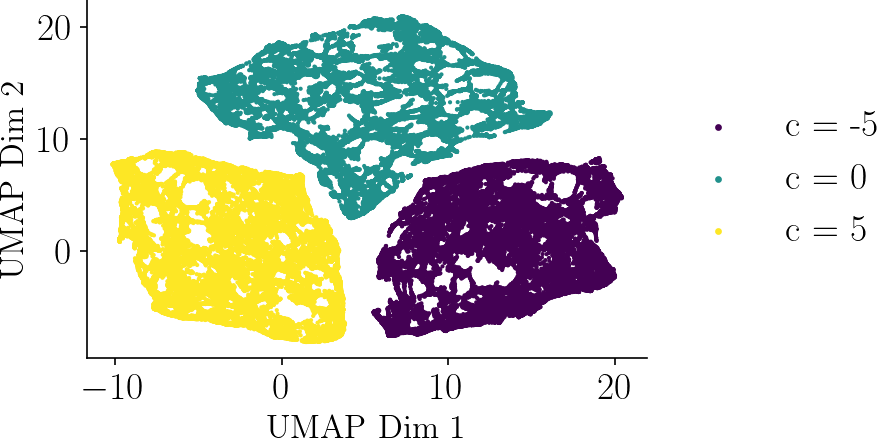

In [110]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(umap_trajectories[:, 0], umap_trajectories[:, 1], color=colors)
for i, n in enumerate(np.linspace(0, umap_trajectories.shape[0]-1, len(contexts)).astype(int)):
    ax.scatter(umap_trajectories[n, 0], umap_trajectories[n, 1], color=colors[n], label=f"c = {contexts[i]}", s=5)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')
plt.show()

# Save figure
# fig.savefig(os.path.join(figure_path, 'rnn_context_umap_trajectories.svg'), transparent=True)

UMAP on context maps

In [124]:
ratemap_colors, ratemap_labels = [], []
for i in range(len(contexts)):
    ratemap_colors.extend([context_colors[i]] * bins**2)
    ratemap_labels.extend([contexts[i]] * bins**2)

In [127]:
ratemaps[np.isnan(ratemaps)] = 0

reducer = umap.UMAP(n_components=2)
umap_trajectories_maps = reducer.fit_transform(ratemaps)

Text(0, 0.5, 'UMAP Dim 2')

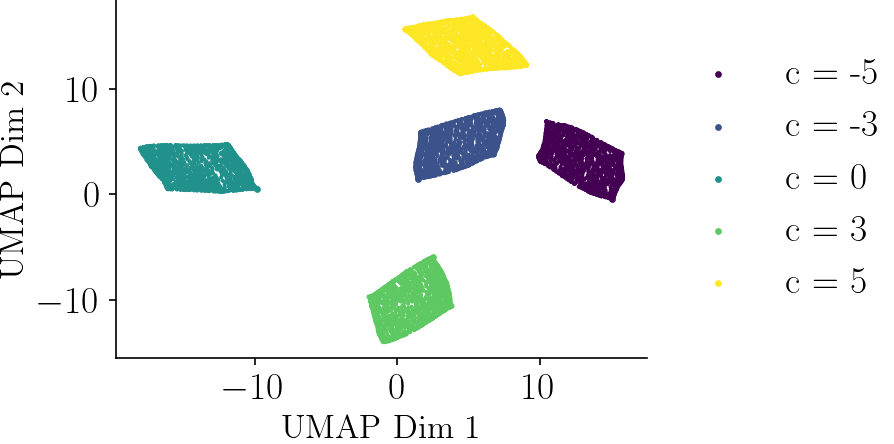

In [128]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(umap_trajectories_maps[:, 0], umap_trajectories_maps[:, 1], color=ratemap_colors)
for i in range(len(contexts)):
    ax.scatter(umap_trajectories_maps[i * bins**2, 0], umap_trajectories_maps[i * bins**2, 1], color=ratemap_colors[i * bins**2], label=f"c = {contexts[i]}", s=5)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel('UMAP Dim 1')
ax.set_ylabel('UMAP Dim 2')

# fig.savefig(os.path.join(figure_path, 'rnn_context_umap_maps.svg'), transparent=True)

## Transformations

In [129]:
# Load model
model_name = f"100 units"
model_name = "100 units no context loss"
model_name = "100 units context initial state"

# Define contexts 
context_1 = -5
context_2 = 0

context_in_initial = True
bins = 32
n_traj = 50000
timesteps = 10

Ts = []
for model in models[model_name]: 

    # Calculate ratemaps
    ratemaps1 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_1, context_in_initial=context_in_initial)
    ratemaps2 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_2, context_in_initial=context_in_initial)
    
    ratemaps1 = ratemaps1.reshape(100, -1)
    ratemaps2 = ratemaps2.reshape(100, -1) 
    
    T = get_orthogonal_transformation(ratemaps1, ratemaps2)
    
    Ts.append(T)

Determine some characteristics of the transformations

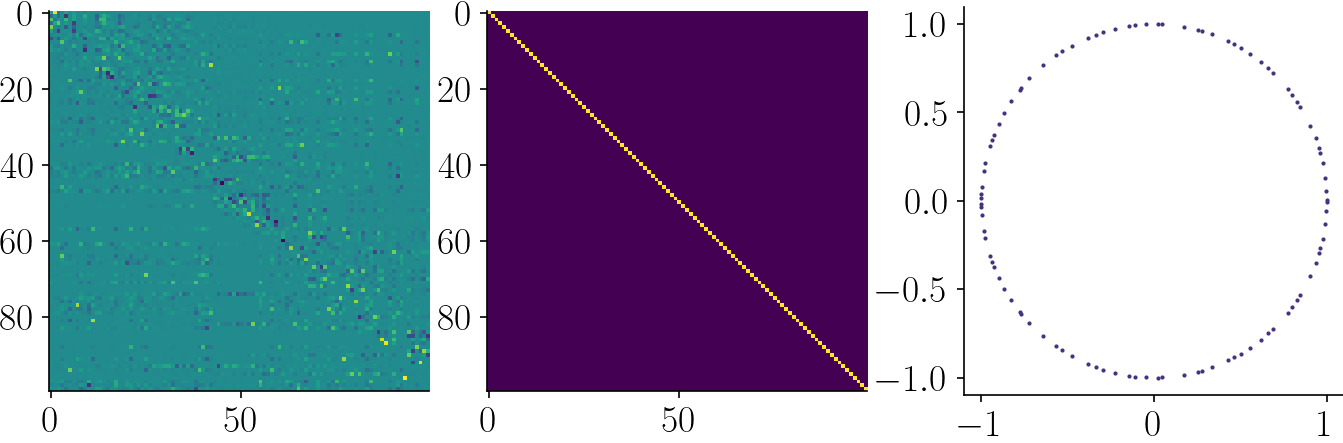

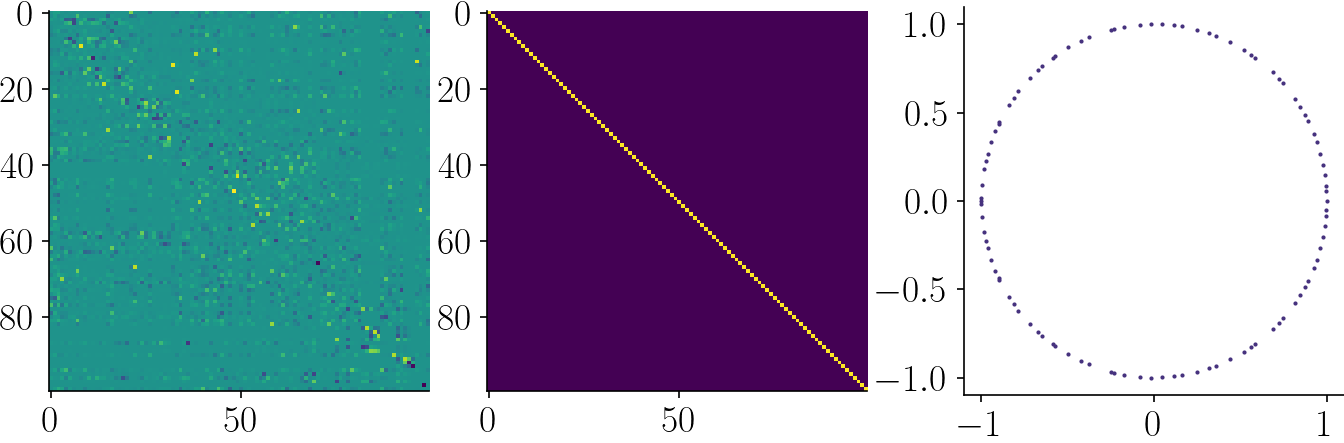

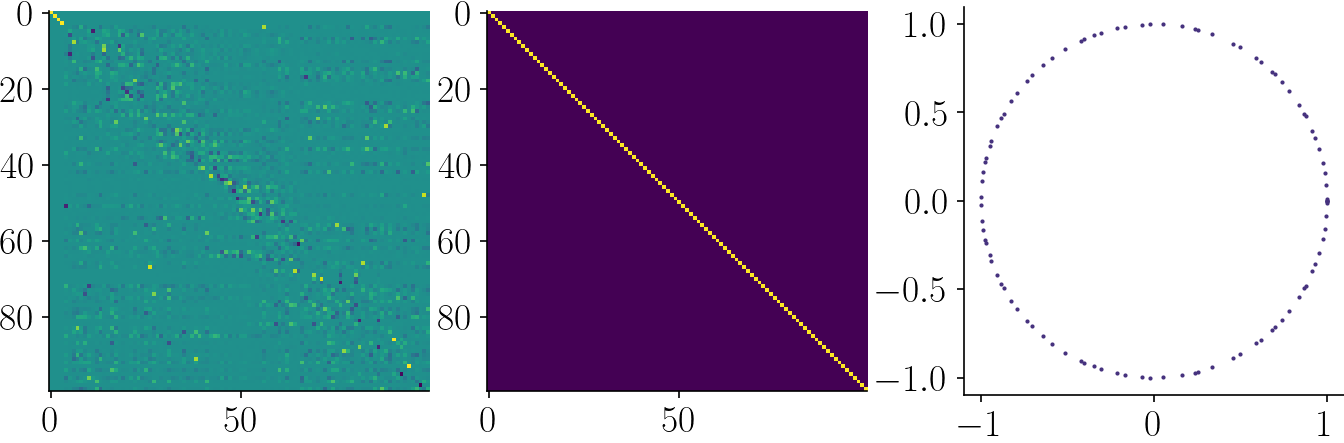

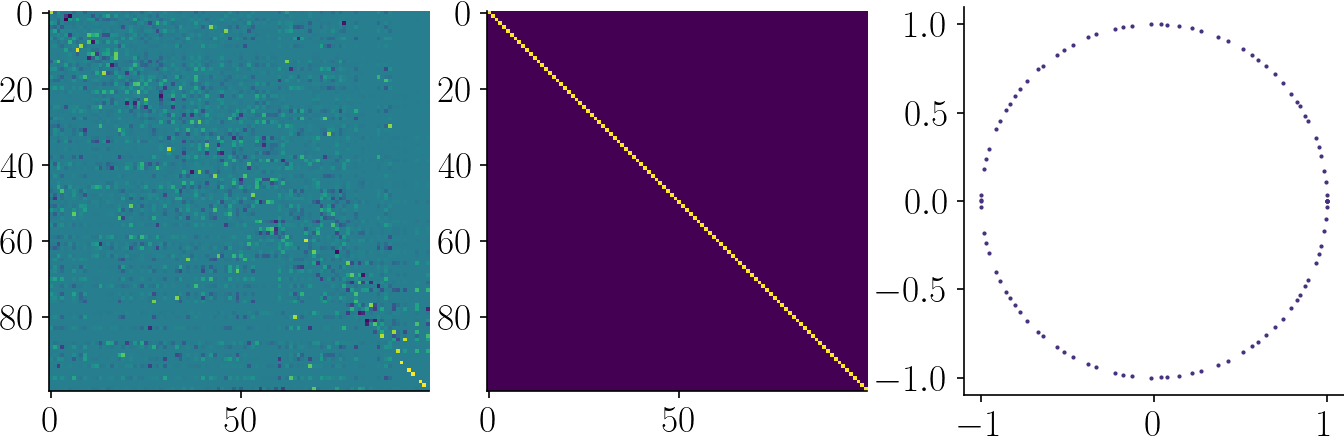

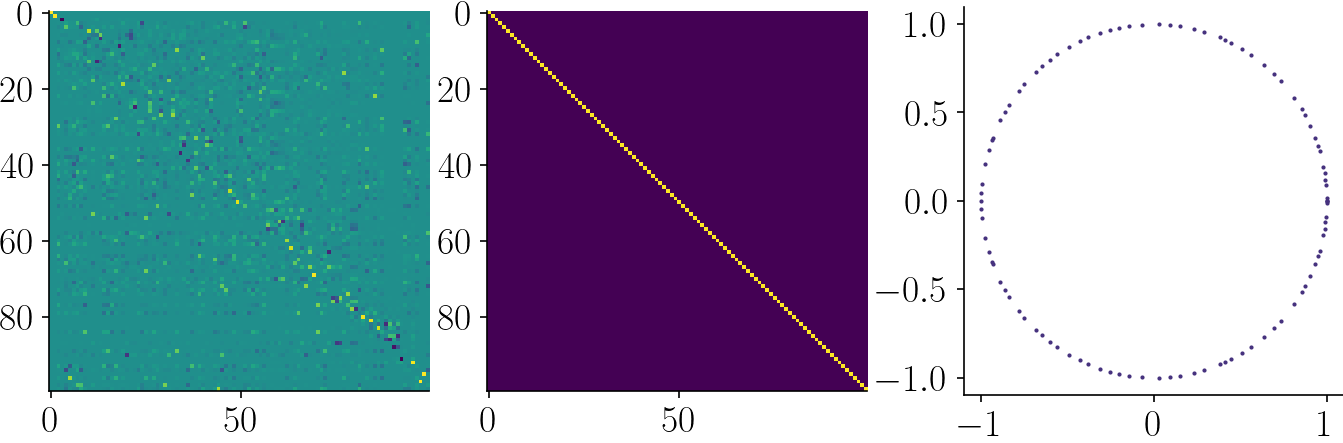

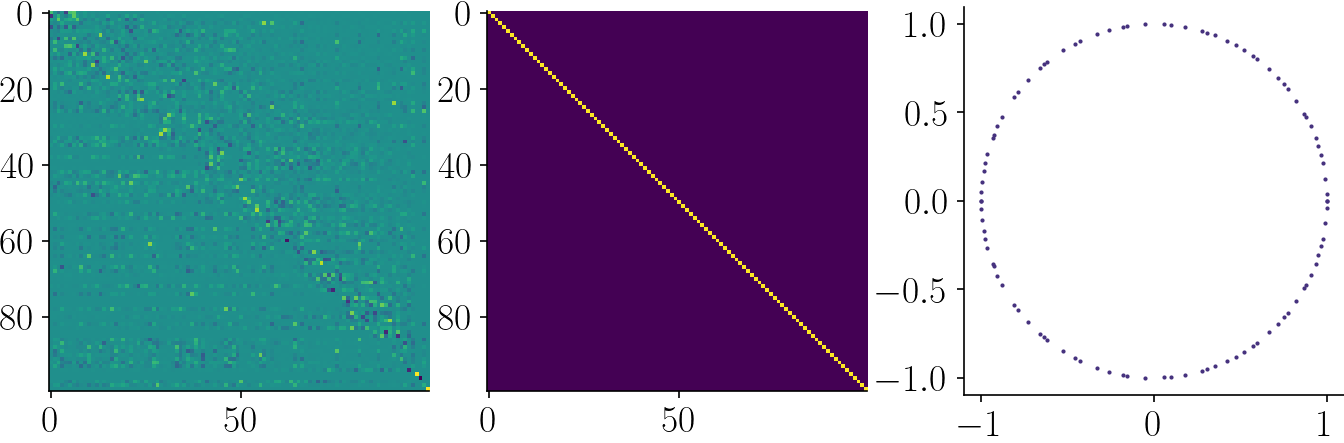

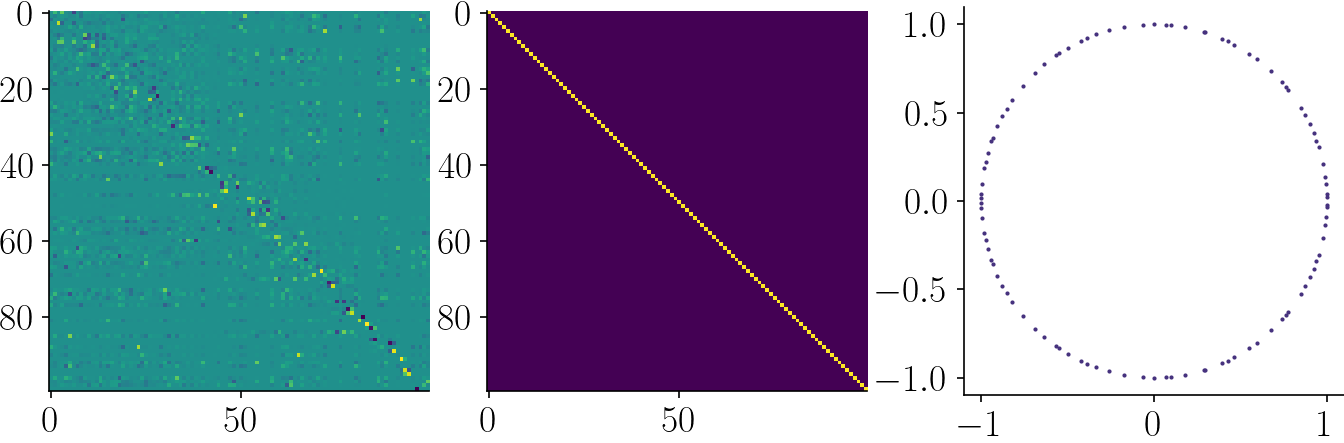

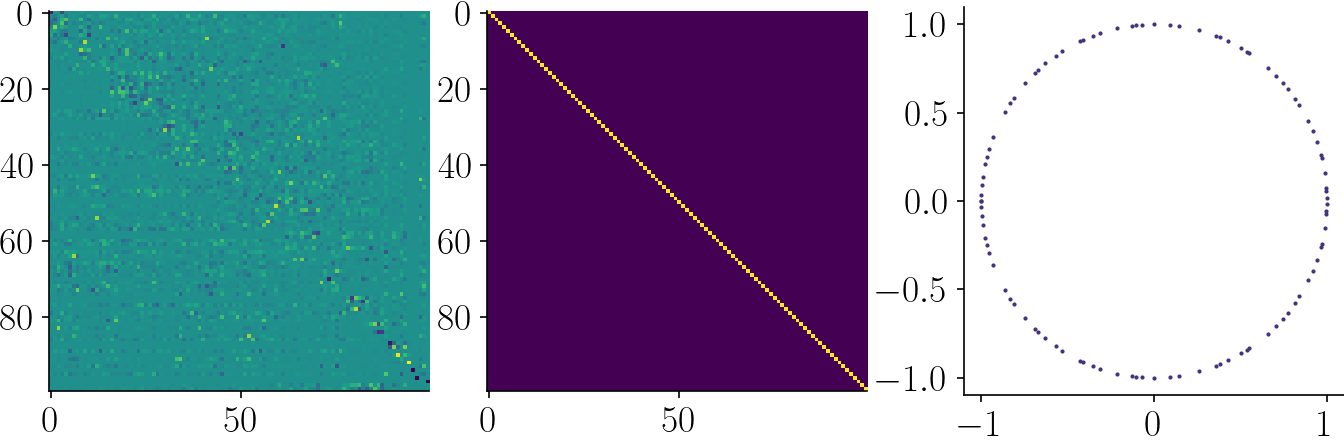

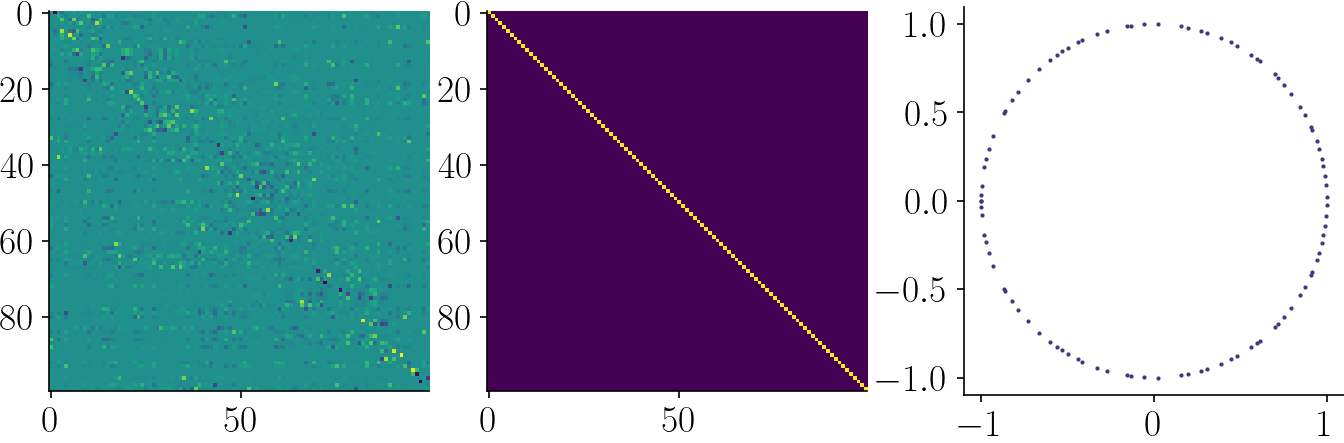

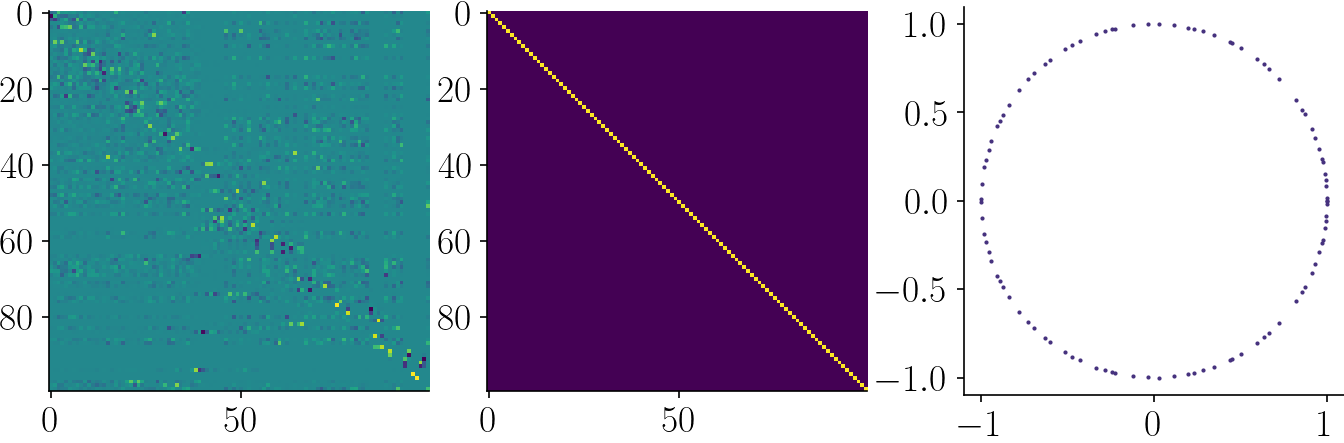

In [130]:
for T in Ts:
    
    # Characterize T
    characteristics = characterize_transformation(T)
    
    fig, axs = plt.subplots(figsize=(9, 3), ncols=3)
    axs[0].imshow(T)
    axs[1].imshow(T @ T.T)
    axs[2].scatter(characteristics['Eigenvalues'].real, characteristics['Eigenvalues'].imag)
    plt.show()
    
    

### Differences between transformations

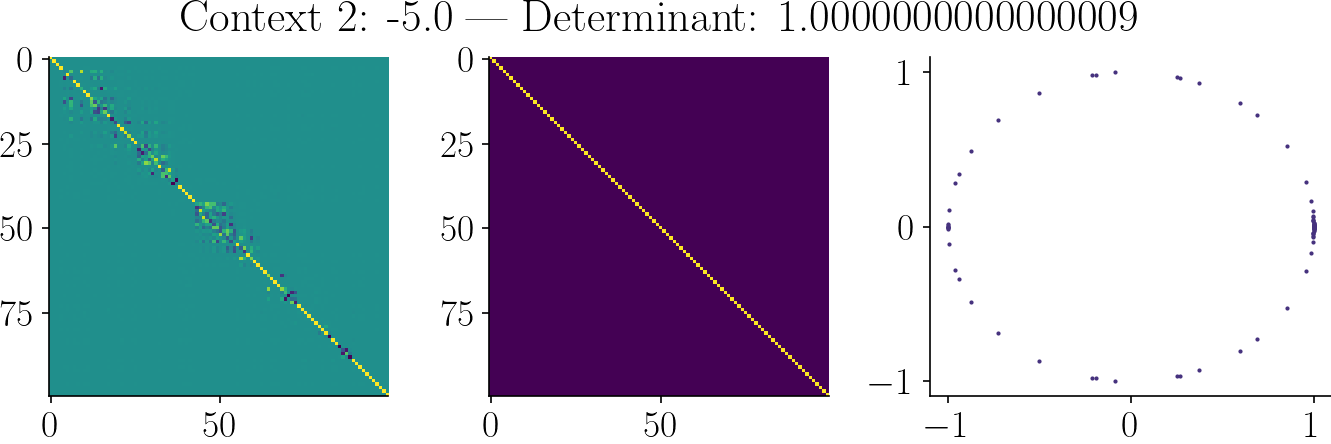

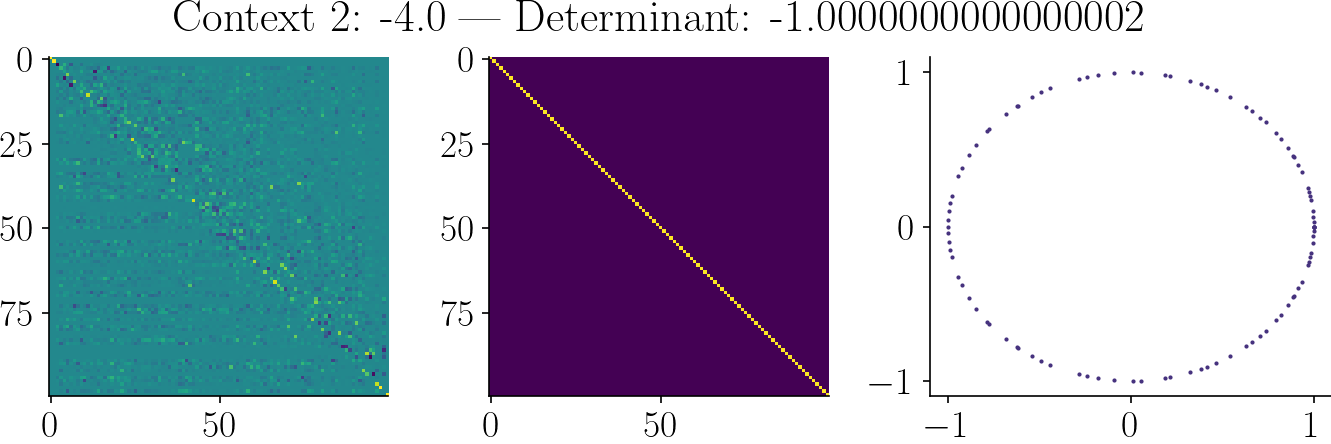

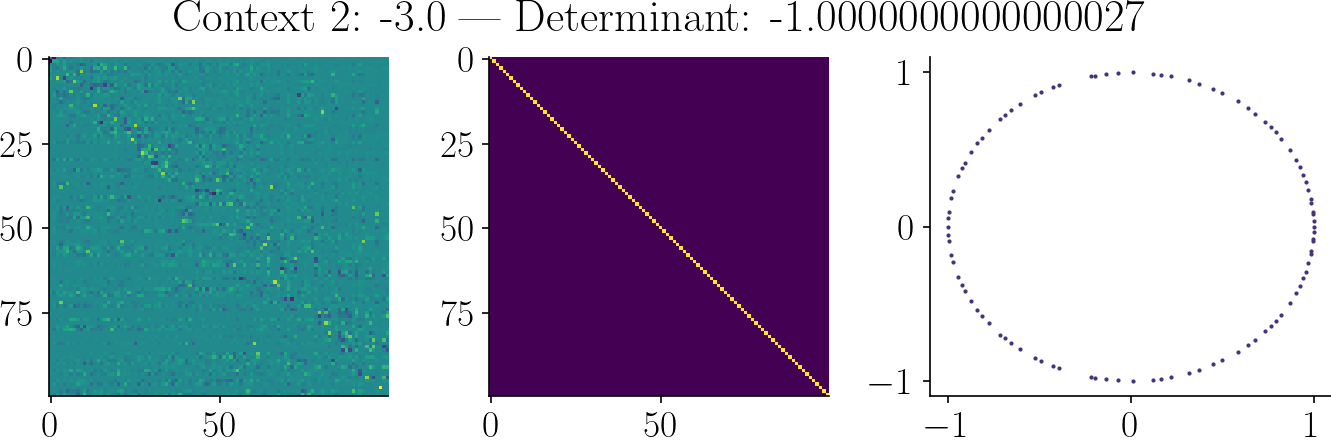

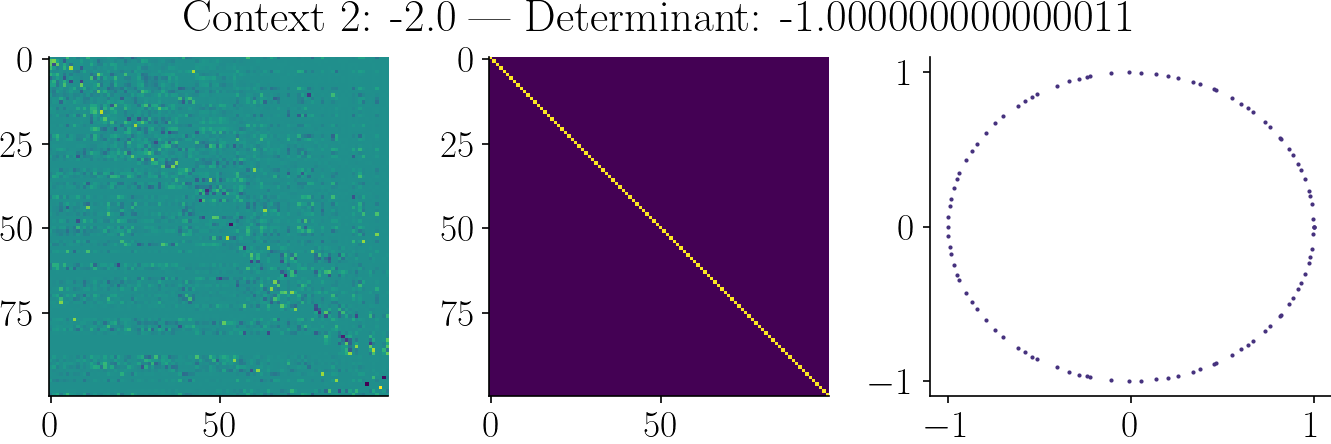

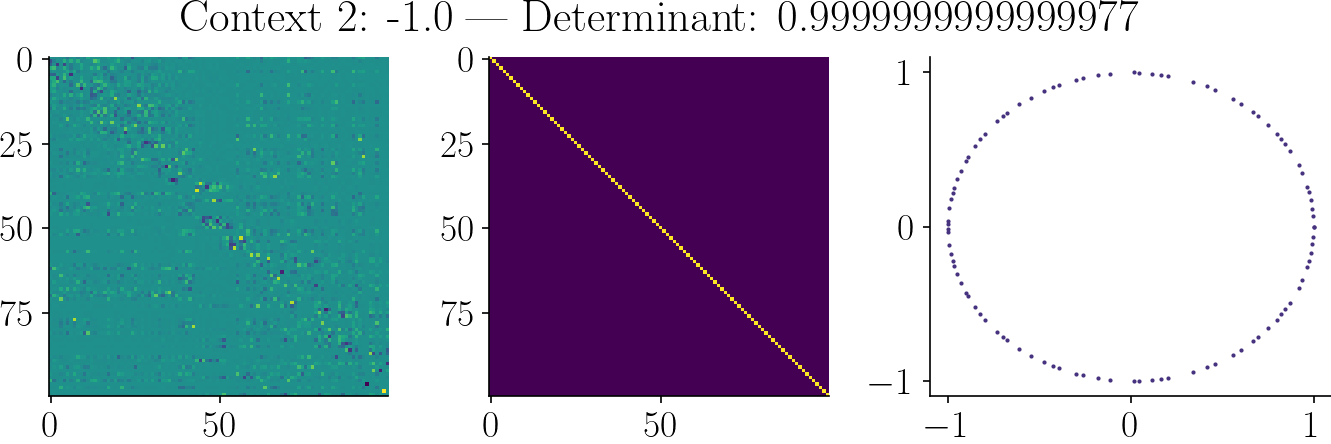

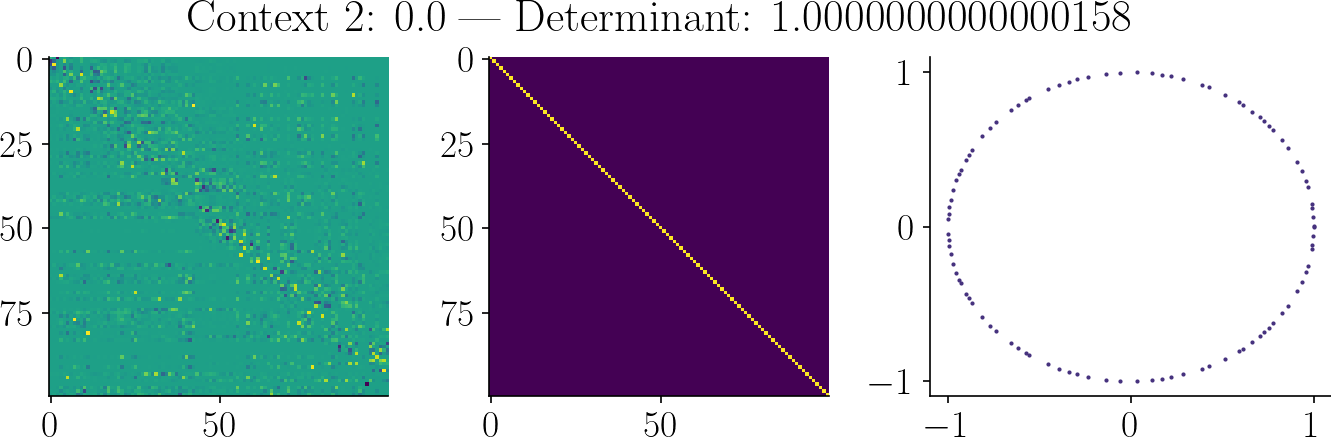

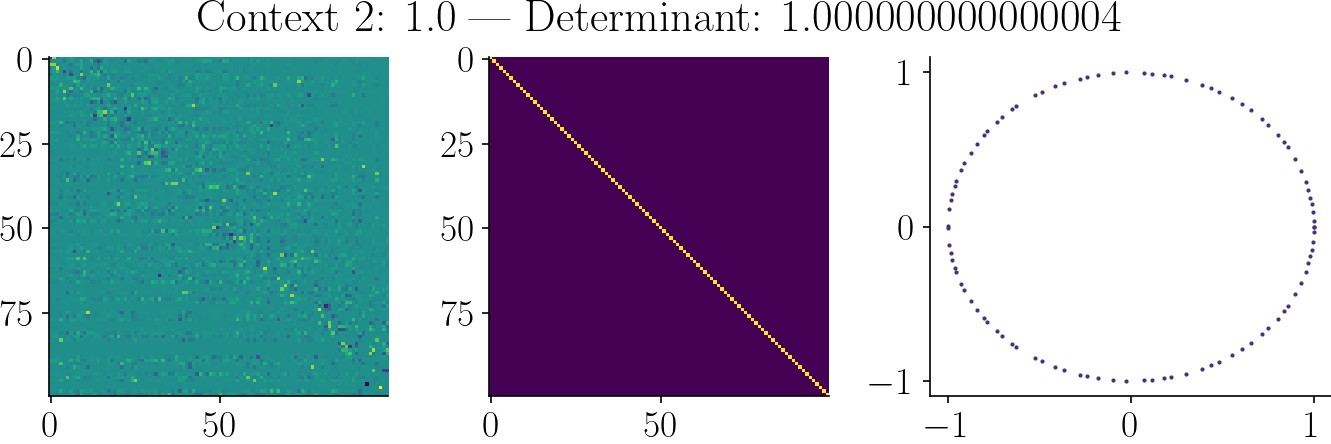

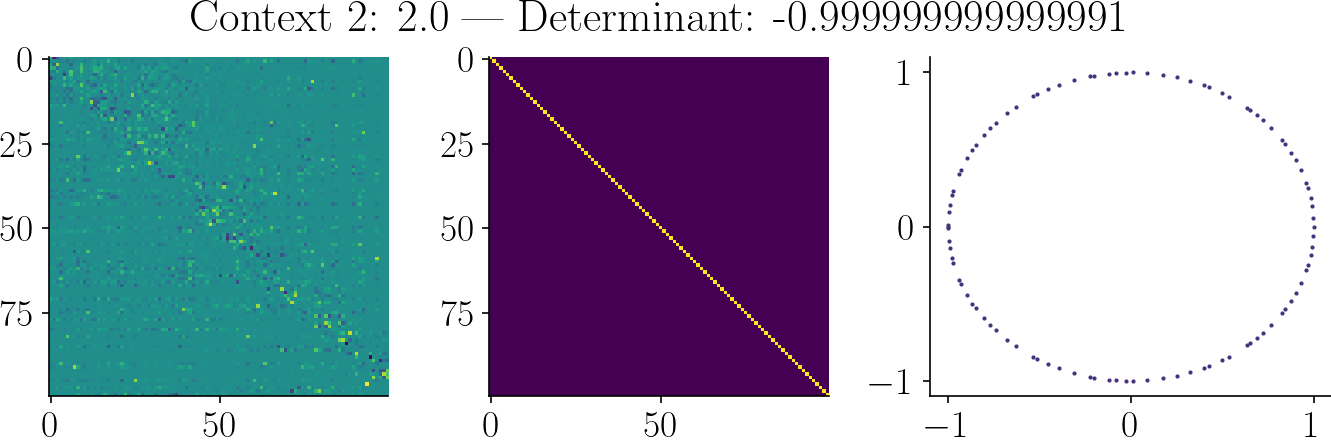

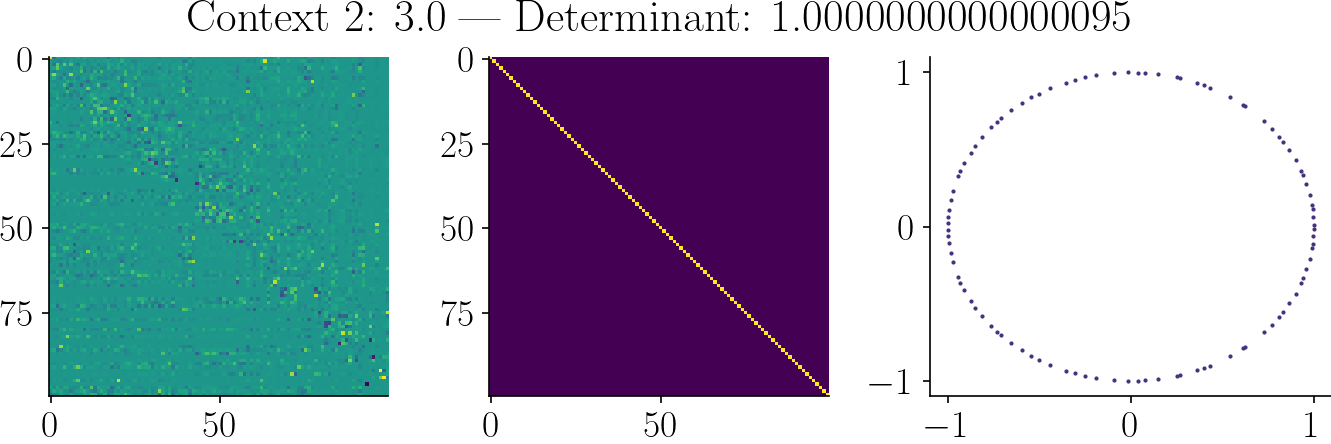

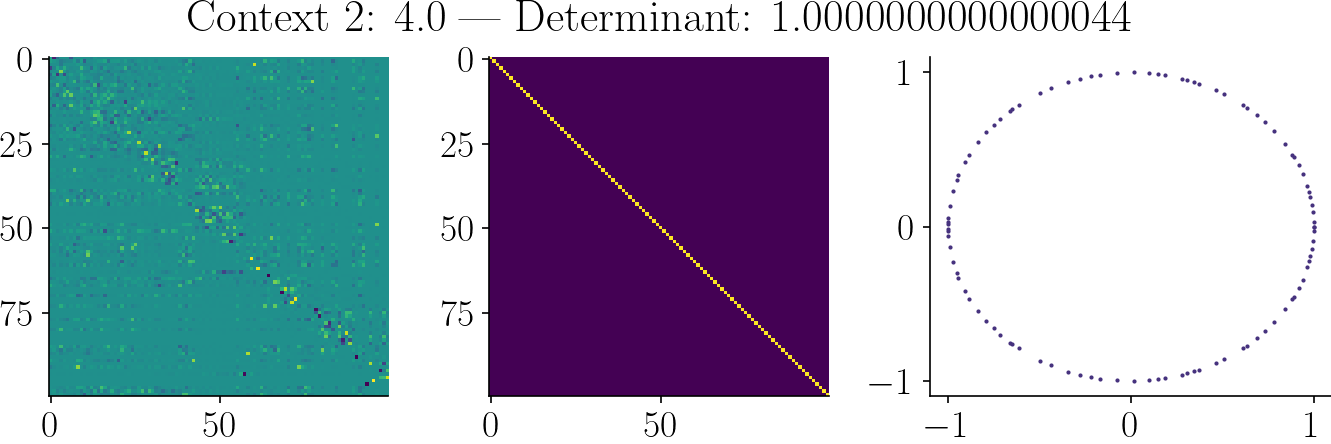

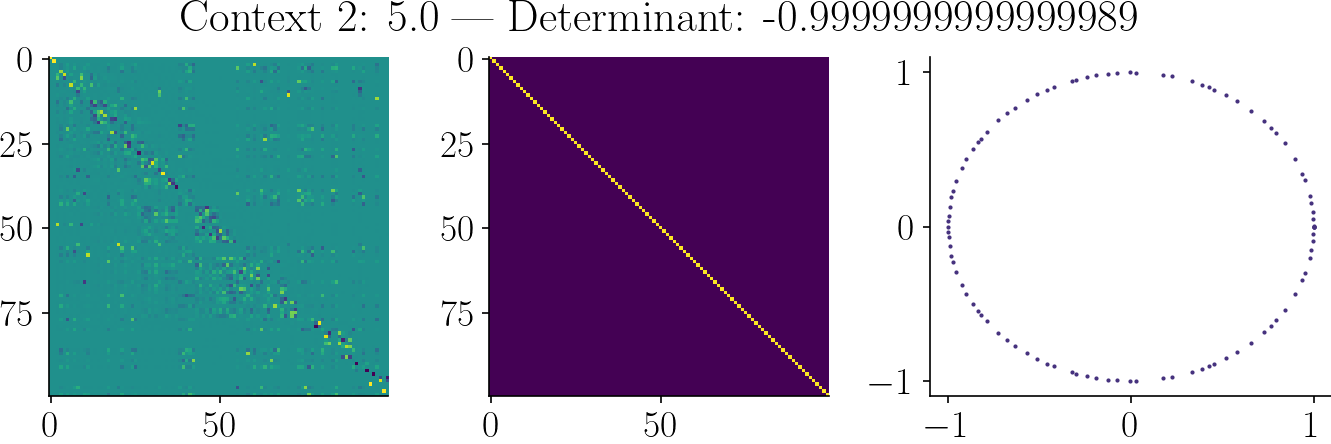

In [131]:
# Load model
model_name = f"100 units context initial state"

model = models[model_name][0]

# Define contexts 
context_1 = -5

bins = 128
n_traj = 100000
timesteps = 10
context_in_initial = True

Ts = []
model_id = []
contexts = []

# for i, model in enumerate(models[model_name]):

ratemaps1 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_1, context_in_initial=context_in_initial)
ratemaps1 = ratemaps1.reshape(100, -1)

for context_2 in np.linspace(context_1, 5, 11):

    # Calculate ratemap
    ratemaps2 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_2, context_in_initial=context_in_initial)
    ratemaps2 = ratemaps2.reshape(100, -1) 
            
    # Find transformation
    T = get_orthogonal_transformation(ratemaps1, ratemaps2)
    
    # Characterize transformation
    characteristics = characterize_transformation(T)

    fig, axs = plt.subplots(figsize=(9, 3), ncols=3)
    axs[0].imshow(T)
    axs[1].imshow(T @ T.T)
    axs[2].scatter(characteristics['Eigenvalues'].real, characteristics['Eigenvalues'].imag)
    fig.suptitle(f"Context 2: {context_2} | Determinant: {characteristics['Determinant']}")
    plt.show()
    
    Ts.append(T)
    contexts.append(context_2)
    
Ts = np.array(Ts)  

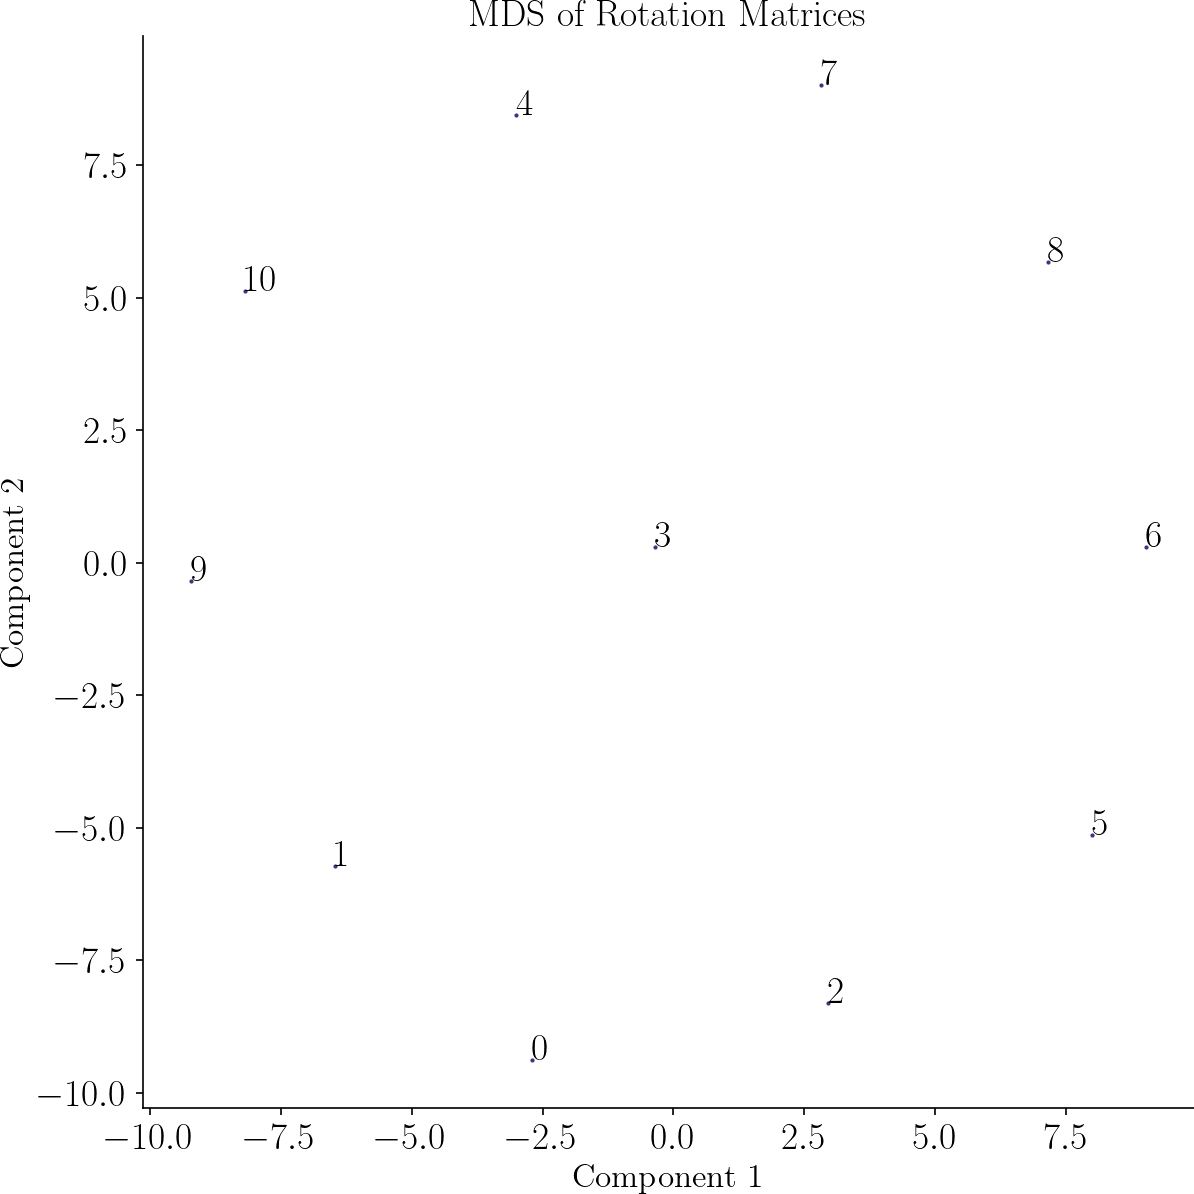

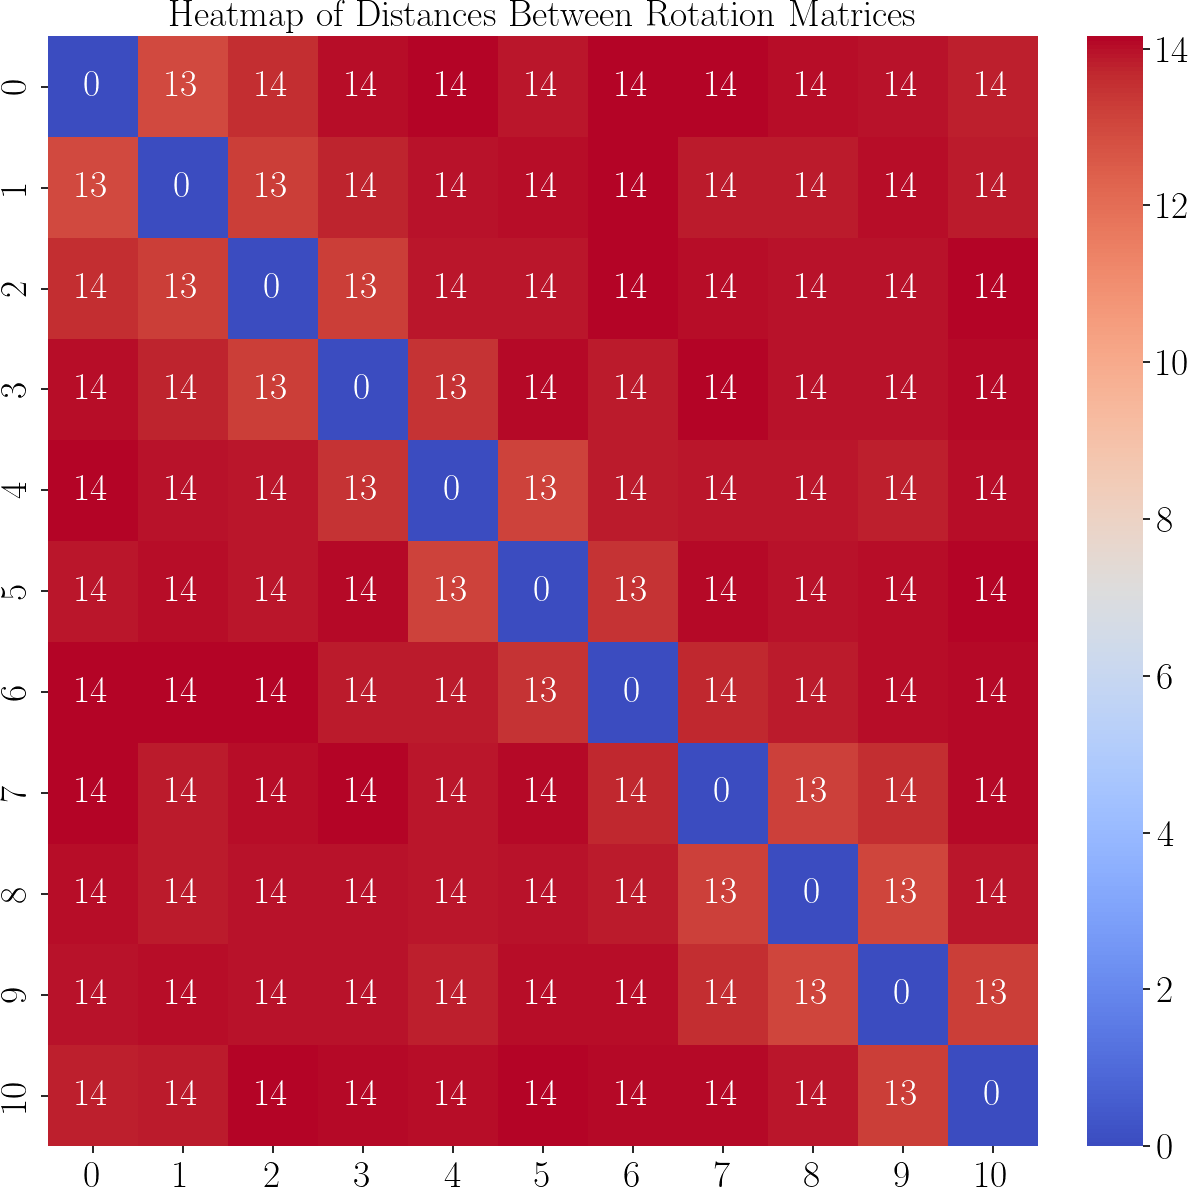

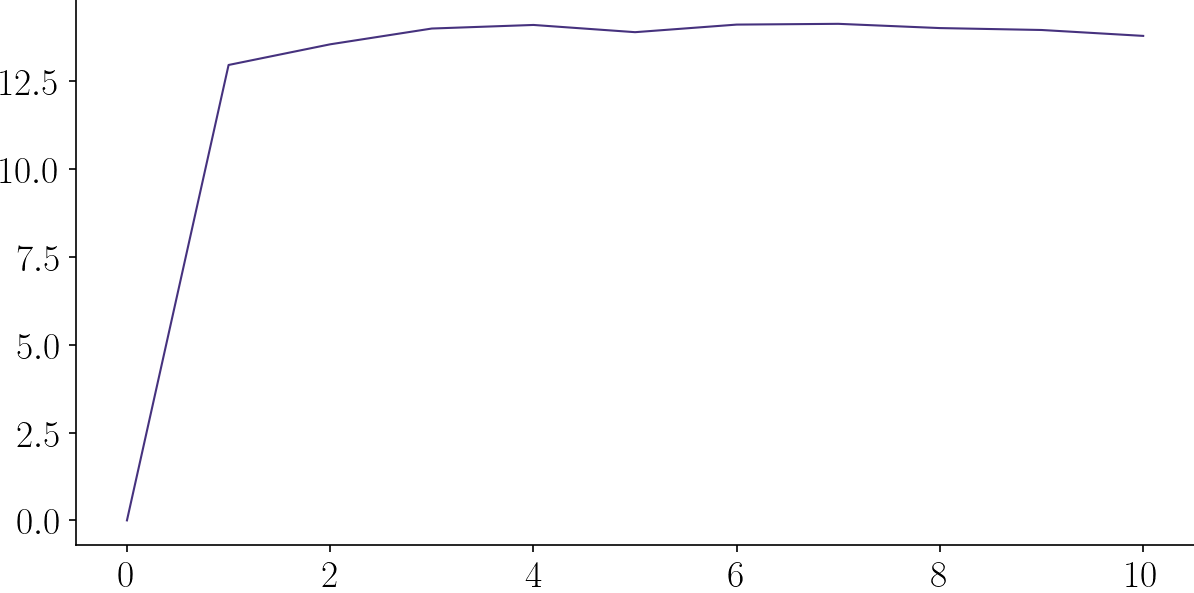

In [132]:
# Compute pairwise distances using the Euclidean metric (default for pdist)
distances = squareform(pdist(Ts.reshape(Ts.shape[0], -1)))  # 'euclidean' is the default metric

# Multidimensional scaling for visualization
mds = MDS(n_components=2, dissimilarity="precomputed")
coords = mds.fit_transform(distances)

# Plotting the MDS result
plt.figure(figsize=(8, 8))
plt.scatter(coords[:, 0], coords[:, 1])
for i in range(Ts.shape[0]):
    plt.text(coords[i, 0], coords[i, 1], str(i))
plt.title('MDS of Rotation Matrices')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# Plotting a heatmap of the distance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(distances, annot=True, cmap='coolwarm')
plt.title('Heatmap of Distances Between Rotation Matrices')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(distances[0])

### Compare context loss vs no context loss

In [ ]:
# Load models
models = {
    "100 units": [torch.load(f"{path}/100 units_{i}.pt") for i in range(5)],
    "100 units no context loss": [torch.load(f"{path}/100 units_no_context_loss_{i}.pt") for i in range(5)],
}

# Load model
model_names = [f"100 units", f"100 units no context loss"]

# Define contexts 
context_1 = -5

bins = 32
n_traj = 100000

results = {}
for model_name in model_names:
    
    print(model_name)
    
    fig, ax = plt.subplots(figsize=(len(models[model_name]) * 5, 5), ncols=len(models[model_name]))
    
    overall_distances = []

    for i, model in enumerate(models[model_name]):
        
        Ts = []
        contexts = []
    
        ratemaps1 = get_ratemaps(model, bins=bins, timesteps=10, n_traj=n_traj, context=context_1)
        ratemaps1 = ratemaps1.reshape(100, -1)
    
        for context_2 in np.linspace(context_1, 5, 11):
    
            # Calculate ratemap
            ratemaps2 = get_ratemaps(model, bins=bins, timesteps=10, n_traj=n_traj, context=context_2)
            ratemaps2 = ratemaps2.reshape(100, -1) 
                    
            # Find transformation
            T = get_orthogonal_transformation(ratemaps1, ratemaps2)
            
            Ts.append(T)
            contexts.append(context_2)
        
        Ts = np.array(Ts)  
        
        distances = squareform(pdist(Ts.reshape(Ts.shape[0], -1)))  # 'euclidean' is the default
        
        sns.heatmap(distances, annot=True, cmap='coolwarm', ax=ax[i])
        
        overall_distances.append(distances)
        
    plt.show()
    
    results[model_name] = np.array(overall_distances)
    

In [ ]:
colors = sns.color_palette("viridis", n_colors=len(models))

fig, ax = plt.subplots(figsize=(9, 3))
for i, model_name in enumerate(results):
    
    values = results[model_name][:, 0, :]
    lower = values.mean(axis=0) - values.std(axis=0)
    upper = values.mean(axis=0) + values.std(axis=0)
    
    ax.plot(values.mean(axis=0)[1:], label=model_name, color=colors[i])
    
    # Show standard deviation
    ax.fill_between(np.arange(values.shape[-1]), lower, upper, color=colors[i], alpha=0.5)

ax.legend()
ax.set_xlabel('Context 2')
ax.set_ylabel('Frobenius norm')


In [ ]:
colors = sns.color_palette("viridis", n_colors=len(models))

fig, ax = plt.subplots(figsize=(9, 3))
for i, model_name in enumerate(results):
    
    values = results[model_name][:, 0, :]
       
    ax.plot(values[:, 1:].T, label=model_name, color=colors[i])

ax.set_xlabel('Context 2')
ax.set_ylabel('Frobenius norm')

    

In [137]:
word = "gosch wenningstedt"

for e in word:
    ascii_code = ord(e)
    
    print(chr(ascii_code +3), end="")
 

jrvfk#zhqqlqjvwhgw

### Errors of transformation matrices

Here, we will check how big the error is that we make by approximating the transformation with an orthogonal matrix.

In [37]:
# Load model
model_name = f"100 units context initial state"
model = models[model_name][0]

bins = 128
n_traj = 100000
timesteps = 10
context_in_initial = True

df = []
for context_1 in np.linspace(-5, 5, 11):

    # Calculate ratemap
    ratemaps1 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_1, context_in_initial=context_in_initial)
    ratemaps1 = ratemaps1.reshape(100, -1)
    
    for context_2 in np.linspace(-5, 5, 11):
    
        # Calculate ratemap
        ratemaps2 = get_ratemaps(model, bins=bins, timesteps=timesteps, n_traj=n_traj, context=context_2, context_in_initial=context_in_initial)
        ratemaps2 = ratemaps2.reshape(100, -1) 
                
        # Find transformation
        T = get_orthogonal_transformation(ratemaps1, ratemaps2)
        
        # Apply transformation
        ratemaps2_approx = T @ (ratemaps1 - np.mean(ratemaps1, axis=1, keepdims=True))
        
        # Compute error
        mse = ((ratemaps2 - np.mean(ratemaps2, axis=1, keepdims=True)) - ratemaps2_approx)
        mse = np.mean(mse ** 2)
        
        df.append(
            {
                "Context 1": context_1,
                "Context 2": context_2,
                "Error": mse
            },
        )
    
df = pd.DataFrame(df)

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    df.pivot(index="Context 1", columns="Context 2", values="Error"), 
    annot=True, 
    cmap='coolwarm',
    fmt=".4f"
)